In [ ]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
from sklearn.datasets import load_iris
from linearmodels.iv import IV2SLS
from statsmodels.formula.api import quantreg, wls
from statsmodels.iolib.summary2 import summary_col
from PIL import Image
from statsmodels.stats.stattools import durbin_watson
from collections import OrderedDict
from linearmodels.iv.results import compare
import doubleml as dml
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import clone
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from doubleml import DoubleMLData, DoubleMLClusterData, DoubleMLPLIV
from doubleml.utils import DMLDummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import holidays
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LassoCV

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-t325rr_g because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [ ]:
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {'MAE': mae, 'RMSE': rmse, 'R²': r2}

def print_metrics(metrics, dataset_type):
    print(f"{dataset_type} Metrics:")
    print(f"  MAE: {metrics['MAE']:.4f}")
    print(f"  RMSE: {metrics['RMSE']:.4f}")
    print(f"  R²: {metrics['R²']:.4f}")

def evaluate_predictions(predictions, true_values, target_name="TargetVariable", time_values=None):
    """
    Evaluate model predictions against true values with metrics and visualizations.

    Args:
        predictions (pd.Series or np.ndarray): Model's predicted values.
        true_values (pd.Series or np.ndarray): True values from the dataset.
        target_name (str): Name of the target variable (for labeling plots and messages).
        time_values (pd.Series): Time values corresponding to the data for coloring.

    Returns:
        dict: Dictionary of metrics including MAE, RMSE, R², and percentage errors.
    """
    # Ensure inputs are aligned
    if isinstance(predictions, np.ndarray):
        predictions = pd.Series(predictions, index=true_values.index)

    # Calculate metrics
    metrics = calculate_metrics(true_values, predictions)

    # Print metrics
    print_metrics(metrics, dataset_type=f"Test - {target_name}")

    # Range of the target variable
    target_min = true_values.min()
    target_max = true_values.max()
    target_range = target_max - target_min
    print(f"{target_name} Range: Min = {target_min}, Max = {target_max}, Range = {target_range}")

    # Percentage errors
    mae_percentage = (metrics['MAE'] / target_range) * 100
    rmse_percentage = (metrics['RMSE'] / target_range) * 100

    print(f"MAE as percentage of range: {mae_percentage:.2f}%")
    print(f"RMSE as percentage of range: {rmse_percentage:.2f}%")

    # Extract years for coloring
    if time_values is not None:
        unique_years = time_values.unique()
        norm = mcolors.Normalize(vmin=min(unique_years), vmax=max(unique_years))
        cmap = cm.viridis
        colors = cmap(norm(time_values))
    else:
        colors = 'blue'  # Default color if no time_values provided

    # Visualizations
    # Scatter plot: Predicted vs Actual
    plt.scatter(true_values, predictions, c=colors, alpha=0.6)
    plt.plot([target_min, target_max], [target_min, target_max], 'r--', label='Perfect prediction')  # Perfect prediction line
    plt.title(f'Predicted vs. Actual {target_name}')
    plt.xlabel(f'Actual {target_name}')
    plt.ylabel(f'Predicted {target_name}')
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label='Year')
    plt.legend()
    plt.show()

    # Residuals plot
    residuals = true_values - predictions
    plt.scatter(true_values, residuals, c=colors, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
    plt.title(f'Residuals vs. Actual {target_name}')
    plt.xlabel(f'Actual {target_name}')
    plt.ylabel('Residuals')
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label='Year')
    plt.legend()
    plt.show()

    # Return metrics and percentages
    return {
        "Metrics": metrics,
        "MAE_Percentage": mae_percentage,
        "RMSE_Percentage": rmse_percentage
    }

In [ ]:
def evaluate_predictions_country(predictions, true_values, target_name="TargetVariable", country_values=None, title="Country"):
    """
    Evaluate model predictions against true values with metrics and visualizations.

    Args:
        predictions (pd.Series or np.ndarray): Model's predicted values.
        true_values (pd.Series or np.ndarray): True values from the dataset.
        target_name (str): Name of the target variable (for labeling plots and messages).
        country_values (pd.Series or np.ndarray): Country values corresponding to the data for coloring.

    Returns:
        dict: Dictionary of metrics including MAE, RMSE, R², and percentage errors.
    """
    import random
    from matplotlib.colors import ListedColormap

    # Ensure inputs are aligned
    if isinstance(predictions, np.ndarray):
        predictions = pd.Series(predictions, index=true_values.index)

    # Calculate metrics
    metrics = calculate_metrics(true_values, predictions)

    # Print metrics
    print_metrics(metrics, dataset_type=f"Test - {target_name}")

    # Range of the target variable
    target_min = true_values.min()
    target_max = true_values.max()
    target_range = target_max - target_min
    print(f"{target_name} Range: Min = {target_min}, Max = {target_max}, Range = {target_range}")

    # Percentage errors
    mae_percentage = (metrics['MAE'] / target_range) * 100
    rmse_percentage = (metrics['RMSE'] / target_range) * 100

    print(f"MAE as percentage of range: {mae_percentage:.2f}%")
    print(f"RMSE as percentage of range: {rmse_percentage:.2f}%")

    # Generate distinct colors for each unique country
    if country_values is not None:
        unique_countries = np.unique(country_values)
        num_countries = len(unique_countries)

        # Generate a list of random, unique colors
        random.seed(42)  # Ensures reproducibility
        colors = [
            (random.random(), random.random(), random.random())
            for _ in range(num_countries)
        ]
        cmap = ListedColormap(colors)

        # Map each country to a unique color
        color_mapping = {country: colors[idx] for idx, country in enumerate(unique_countries)}
        dot_colors = [color_mapping[country] for country in country_values]
    else:
        dot_colors = 'blue'  # Default color if no country_values provided
        color_mapping = None

    # Visualizations
    # Scatter plot: Predicted vs Actual
    plt.figure(figsize=(10, 6))
    plt.scatter(true_values, predictions, c=dot_colors, alpha=0.6)
    plt.plot([target_min, target_max], [target_min, target_max], 'r--', label='Perfect prediction')  # Perfect prediction line
    plt.title(f'Predicted vs. Actual {target_name}')
    plt.xlabel(f'Actual {target_name}')
    plt.ylabel(f'Predicted {target_name}')
    if country_values is not None:
        handles = [
            plt.Line2D([0], [0], marker='o', color=color_mapping[country], linestyle='', label=country)
            for country in unique_countries
        ]
        plt.legend(handles=handles, title=title, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

    # Residuals plot
    plt.figure(figsize=(10, 6))
    residuals = true_values - predictions
    plt.scatter(true_values, residuals, c=dot_colors, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
    plt.title(f'Residuals vs. Actual {target_name}')
    plt.xlabel(f'Actual {target_name}')
    plt.ylabel('Residuals')
    if country_values is not None:
        plt.legend(handles=handles, title=title, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

    # Return metrics and percentages
    return {
        "Metrics": metrics,
        "MAE_Percentage": mae_percentage,
        "RMSE_Percentage": rmse_percentage
    }

In [ ]:
def prepare_data(
    data,
    base_covariates=None,
    include_interactions=None,
    dependent_variable='consumption_normalized'
):
    data = data.copy()
    data = data[data["PriceArea"] != "DE_AT_LU"]
    data['Time'] = pd.to_datetime(data['Time'])
    data['Year'] = data['Time'].dt.year
    data = data.sort_values(by='Time')
    data['Country'] = data['PriceArea']
    data['consumption_normalized'] = (
        data['ConsumptionValue'] /
        data.groupby(['Country', data['Time'].dt.year])['ConsumptionValue'].transform('mean')
    )
    data['consumption_norm_peak'] = (
        data['ConsumptionValue'] /
        data.groupby(['Country', 'Year'])['ConsumptionValue'].transform('max')
    )

    data['Total_Wind_Generation'] = (
        data['Wind_Offshore'].fillna(0) + data['Wind_Onshore'].fillna(0)
    )

    # Dummies
    data = pd.get_dummies(data, columns=['block'], drop_first=False)
    data = pd.get_dummies(data, columns=['PriceArea'], drop_first=False)
    price_area_columns = [col for col in data.columns if col.startswith('PriceArea_')]
    for col in price_area_columns:
        data[col] = data[col].astype(int)

    data['HourOfWeek'] = data['Time'].dt.dayofweek * 24 + data['Time'].dt.hour
    data = pd.get_dummies(data, columns=['HourOfWeek'], drop_first=False)

    data['Month'] = data['Time'].dt.month
    data = pd.get_dummies(data, columns=['Month'], drop_first=False)

    # Rolling features
    data['RollingMean24h'] = (
        data.groupby(['Country', 'Year'])[dependent_variable]
        .transform(lambda x: x.rolling(window=24, min_periods=12).mean())
    )
    data['RollingStd24h_Price'] = (
        data.groupby(['Country', 'Year'])['DayAheadPriceEUR']
        .transform(lambda x: x.rolling(window=24, min_periods=12).std())
    )

    # Weekend / spike flags
    data['IsWeekend'] = (data['Time'].dt.dayofweek >= 5).astype(int)

    # Step 2: Add interaction terms if specified
    interaction_covariates = []
    block_dummy_columns = [col for col in data.columns if col.startswith('block_')]

    if include_interactions:
        for block_col in block_dummy_columns:
            if 'block' in include_interactions:
                for interaction_col in include_interactions['block']:
                    interaction_term = f'{block_col}:{interaction_col}'
                    data[interaction_term] = data[block_col] * data[interaction_col]
                    interaction_covariates.append(interaction_term)


    covariates = list(set(base_covariates + interaction_covariates +
                          [col for col in data.columns if col.startswith('PriceArea_')] +
                          [col for col in data.columns if col.startswith('HourOfWeek_')] +
                          [col for col in data.columns if col.startswith('Month_')]))

    covariates = [col for col in covariates if not (col.startswith('block_') and ':' not in col)]
    endogenous_variable = 'DayAheadPriceEUR'
    instrument_variables = ['Total_Wind_Generation']  # adapt to your case

    key_variables = [dependent_variable, endogenous_variable] + instrument_variables + covariates
    filtered_processed_data = data.dropna(subset=key_variables)


    return filtered_processed_data, covariates

In [ ]:
def dml_rolling_window(filtered_data, base_covariates, manual_params_l=None, manual_params_r = None, manual_params_m=None, param_dist_xgb=None, dependent_variable = 'consumption_normalized'):

    data = filtered_data.copy()

    covariates = base_covariates.copy()


    # Initialize lists to collect predictions and time indices
    predictions_ml_l = []
    predictions_ml_r = []
    predictions_ml_m = []
    time_indices = []
    train_predictions = []
    train_actuals = []
    test_predictions = []
    test_actuals = []
    feature_importances_per_window = []
    fold_metrics = []
    test_years = []
    fold_feature_importance_df = []
    fold_coefficients = []



    train_test_pairs = [
    (2015, 2016, 2017),
    (2016, 2017, 2018),
    (2017, 2018, 2019),
    (2018, 2019, 2020),
    (2019, 2020, 2021),
    (2020, 2021, 2022),
    (2021, 2022, 2023),
    (2022, 2023, 2024)]


    def tune_xgb_model(X, y):
        tscv = TimeSeriesSplit(n_splits=3)
        model = xgb.XGBRegressor(objective="reg:squarederror", tree_method="hist", eval_metric="rmse")
        grid_search = GridSearchCV(model, param_dist_xgb, cv=tscv, n_jobs=-1)
        grid_search.fit(X, y)
        return grid_search.best_params_

    best_params_xgb = None  # Store best params from first window
    best_params_xgb_treat = None
    best_params_xgb_inst = None
    lasso_param = None

    data['Year'] = data['Time'].dt.year
    year_to_indices = data.groupby('Year').indices



    for train_start, train_end, test_year in train_test_pairs:
        train_indices = []
        for y in range(train_start, train_end + 1):
            if y in year_to_indices:
                train_indices.extend(year_to_indices[y])

        test_indices = year_to_indices.get(test_year, [])

        if len(train_indices) == 0 or len(test_indices) == 0:
            print(f"Skipping test year {test_year} due to insufficient data.")
            continue

        train_data = data.iloc[train_indices]
        test_data = data.iloc[test_indices]



        print(f"\nTest Year: {test_year} | Training Years: {train_start} to {train_end}")
        print(f"Train samples: {len(train_indices)} | Test samples: {len(test_indices)}")


        X_train = train_data[covariates]
        y_train_ml_l = train_data[dependent_variable]
        d_train_ml_r = train_data['DayAheadPriceEUR']
        z_train_ml_m_1 = train_data['Total_Wind_Generation']


        if best_params_xgb is None and manual_params_l is None:
            best_params_xgb = tune_xgb_model(X_train, y_train_ml_l)
            print("Best L Parameters:", best_params_xgb)

        if best_params_xgb_treat is None and manual_params_r is None:
            best_params_xgb_treat = tune_xgb_model(X_train, d_train_ml_r)
            print("Best R Parameters:", best_params_xgb_treat)


        if best_params_xgb_inst is None and manual_params_m is None:
            best_params_xgb_inst = tune_xgb_model(X_train, z_train_ml_m_1)
            print("Best M Parameters:", best_params_xgb_inst)

        learner_l = xgb.XGBRegressor(**(manual_params_l if manual_params_l else best_params_xgb))
        learner_r = xgb.XGBRegressor(**(manual_params_r if manual_params_r else best_params_xgb_treat))
        learner_m = xgb.XGBRegressor(**(manual_params_m if manual_params_m else best_params_xgb_inst))
            # Train each model on the training set (fixed window)
        learner_l.fit(X_train, y_train_ml_l)
        learner_r.fit(X_train, d_train_ml_r)
        learner_m.fit(X_train, z_train_ml_m_1)

        feature_importances_per_window.append(learner_l.feature_importances_)

            # Predict on the test set (next year)
        X_test = test_data[covariates]
        y_test_ml_l = test_data[dependent_variable]
        d_test_ml_r = test_data['DayAheadPriceEUR']
        z_test_ml_m_1 = test_data['Total_Wind_Generation']
        pred_l = learner_l.predict(X_test)
        pred_r = learner_r.predict(X_test)
        pred_m = learner_m.predict(X_test)

            # Predict on the train set (next year)
        train_predictions.extend(learner_l.predict(X_train))
        train_actuals.extend(y_train_ml_l)
        test_predictions.extend(learner_l.predict(X_test))
        test_actuals.extend(y_test_ml_l)

            # Append predictions and indices to the lists
        predictions_ml_l.extend(pred_l)
        predictions_ml_r.extend(pred_r)
        predictions_ml_m.extend(pred_m)
        time_indices.extend(test_data.index.tolist())

        plt.figure(figsize=(12, 4))
        plt.plot(test_actuals[:500], label='Actual')
        plt.plot(test_predictions[:500], label='Predicted')
        plt.title("First 500 test predictions vs actuals")
        plt.legend()
        plt.show()

        fold_mae = mean_absolute_error(y_test_ml_l, pred_l)
        fold_rmse = mean_squared_error(y_test_ml_l, pred_l, squared=False)
        fold_r2 = r2_score(y_test_ml_l, pred_l)
        fold_rr = r2_score(d_test_ml_r, pred_r)
        fold_rz = r2_score(z_test_ml_m_1, pred_m)
        print("Test error l:", fold_r2)
        print("Test error r:", fold_rr)
        print("Test error m:", fold_rz)

        fold_metrics.append({
            'Test Year': test_year,
            'MAE': fold_mae,
            'RMSE': fold_rmse,
            'R2': fold_r2
        })
        test_years.append(test_year)

        fold_feature_importance_df.append(pd.DataFrame({
            'Feature': covariates,
            'Importance': learner_l.feature_importances_,
            'Year': test_year
        }))

        dml_data_fold = dml.DoubleMLClusterData(
            test_data.reset_index(drop=True),
            y_col=dependent_variable,
            d_cols='DayAheadPriceEUR',
            z_cols='Total_Wind_Generation',
            x_cols=covariates,
            cluster_cols=['Country']
        )

        dml_fold = dml.DoubleMLPLIV(dml_data_fold, dml.utils.DMLDummyRegressor(), dml.utils.DMLDummyRegressor(), dml.utils.DMLDummyRegressor())
        dml_fold.fit(external_predictions={
            'DayAheadPriceEUR': {
                'ml_l': pred_l.reshape(-1, 1),
                'ml_r': pred_r.reshape(-1, 1),
                'ml_m': pred_m.reshape(-1, 1)
            }
        })
        fold_coefficients.append({
            'Year': test_year,
            'coef': dml_fold.coef,
            'se': dml_fold.se,
            't': dml_fold.t_stat,
            'p': dml_fold.pval,
        })


    # Calculate metrics for the entire model
    train_mae = mean_absolute_error(train_actuals, train_predictions)
    train_rmse = mean_squared_error(train_actuals, train_predictions, squared=False)
    train_r2 = r2_score(train_actuals, train_predictions)

    test_mae = mean_absolute_error(test_actuals, test_predictions)
    test_rmse = mean_squared_error(test_actuals, test_predictions, squared=False)
    test_r2 = r2_score(test_actuals, test_predictions)

    print("Overall Train Metrics:")
    print(f"MAE: {train_mae}, RMSE: {train_rmse}, R²: {train_r2}")

    print("Overall Test Metrics:")
    print(f"MAE: {test_mae}, RMSE: {test_rmse}, R²: {test_r2}")



    feature_importances_array = np.array(feature_importances_per_window)
    mean_importances = feature_importances_array.mean(axis=0)
    std_importances = feature_importances_array.std(axis=0)
    importance_df = pd.DataFrame({
        'Feature': covariates,
        'Mean Importance': mean_importances,
        'Std Importance': std_importances
    }).sort_values(by='Mean Importance', ascending=False)


    # Convert predictions lists to numpy arrays
    filtered_data = data.loc[data.index.isin(time_indices)].copy()

    #### predictins dataset? original dataset?

    predictions_ml_l = np.array(predictions_ml_l).reshape(-1, 1)
    predictions_ml_r = np.array(predictions_ml_r).reshape(-1, 1)
    predictions_ml_m = np.array(predictions_ml_m).reshape(-1, 1)


    pred_dict = {
        'DayAheadPriceEUR': {
            'ml_l': predictions_ml_l,
            'ml_r': predictions_ml_r,
            'ml_m': predictions_ml_m
        }
    }

    # Initialize DoubleML data object
    obj_dml_data = dml.DoubleMLClusterData(
        filtered_data,
        y_col=dependent_variable,
        d_cols='DayAheadPriceEUR',
        z_cols='Total_Wind_Generation',  # Use original instruments (not the lags) for DoubleML
        x_cols=covariates,
        cluster_cols=['Country']
    )
    # Use dummy regressors for DoubleML
    ml_l = dml.utils.DMLDummyRegressor()
    ml_m = dml.utils.DMLDummyRegressor()
    ml_r = dml.utils.DMLDummyRegressor()

    # Initialize and fit DoubleML with external predictions
    dml_pliv_obj = dml.DoubleMLPLIV(obj_dml_data, ml_l, ml_m, ml_r)
    dml_pliv_obj.fit(external_predictions=pred_dict)

    print(dml_pliv_obj)
    filtered_data["Prrediction"] = dml_pliv_obj.predictions["ml_l"].ravel()
    filtered_data["Residuals"] = dml_pliv_obj.predictions["ml_l"].ravel() - filtered_data[dependent_variable]
    importance_all_folds_df = pd.concat(fold_feature_importance_df, ignore_index=True)
    fold_metrics_df = pd.DataFrame(fold_metrics)



    return dml_pliv_obj, filtered_data, importance_df, fold_metrics_df, importance_all_folds_df, fold_coefficients

In [ ]:
data_1 = pd.read_csv('/workspace/new_data/filtered_data_with_holidays_updated.csv', index_col=0)
data_1

Unnamed: 0                 Time PriceArea  ConsumptionValue  \
Unnamed: 0.1                                                                
0.0                  0.0  2015-01-01 01:00:00        CH            7654.0   
1.0                 17.0  2015-01-01 01:00:00        SK            2728.0   
2.0                 16.0  2015-01-01 01:00:00        SI            1045.0   
3.0                 15.0  2015-01-01 01:00:00        PT            5124.0   
4.0                 10.0  2015-01-01 01:00:00      DK_2            1305.0   
...                  ...                  ...       ...               ...   
NaN                  NaN  2025-01-01 00:00:00      SE_2            1791.0   
NaN                  NaN  2025-01-01 00:00:00      SE_3            9658.0   
NaN                  NaN  2025-01-01 00:00:00      SE_4            2146.0   
NaN                  NaN  2025-01-01 00:00:00        SI            1159.0   
NaN                  NaN  2025-01-01 00:00:00        SK            2524.0   

              DayAheadPriceEUR  WeatherWindSpeed  WeatherTemperature    Year  \
Unnamed: 0.1                                                                   
0.0                      38.08          3.647062          267.706482  2015.0   
1.0                      22.06          3.991796          265.239655  2015.0   
2.0                      22.20          4.172168          265.189819  2015.0   
3.0                      47.33          6.417383          279.455658  2015.0   
4.0                      16.04         10.561893          276.635590  2015.0   
...                        ...               ...                 ...     ...   
NaN                       3.69          3.096981          262.690735  2025.0   
NaN                       2.47          7.332158          272.276581  2025.0   
NaN                       2.04         14.230573          276.445221  2025.0   
NaN                     129.07          3.418118          274.394440  2025.0   
NaN                     138.56          6.014961          268.740997  2025.0   

              Month  Day  ...         YearMonthDay  Price_Area  Price_gas  \
Unnamed: 0.1              ...                                               
0.0             1.0  1.0  ...           2015-01-01        cegh     20.650   
1.0             1.0  1.0  ...           2015-01-01          cz     20.650   
2.0             1.0  1.0  ...           2015-01-01        cegh     20.650   
3.0             1.0  1.0  ...           2015-01-01          cz     20.650   
4.0             1.0  1.0  ...           2015-01-01         etf     20.650   
...             ...  ...  ...                  ...         ...        ...   
NaN             1.0  1.0  ...  2025-01-01 00:00:00         etf     48.889   
NaN             1.0  1.0  ...  2025-01-01 00:00:00         etf     48.889   
NaN             1.0  1.0  ...  2025-01-01 00:00:00         etf     48.889   
NaN             1.0  1.0  ...  2025-01-01 00:00:00        cegh     48.889   
NaN             1.0  1.0  ...  2025-01-01 00:00:00          cz     48.889   

              Price_coal  Price_EUA IsHoliday  B16  B18     B19 Price_gas_ttf  
Unnamed: 0.1                                                                   
0.0                 66.7       7.34       1.0  NaN  NaN     NaN           NaN  
1.0                 66.7       7.34       1.0  NaN  NaN     NaN           NaN  
2.0                 66.7       7.34       1.0  NaN  NaN     NaN           NaN  
3.0                 66.7       7.34       1.0  NaN  NaN     NaN           NaN  
4.0                 66.7       7.34       1.0  NaN  NaN     NaN           NaN  
...                  ...        ...       ...  ...  ...     ...           ...  
NaN                114.5      73.00       NaN  0.0  NaN   243.0           NaN  
NaN                114.5      73.00       NaN  0.0  NaN  2131.0           NaN  
NaN                114.5      73.00       NaN  1.0  NaN  1849.0           NaN  
NaN                114.5      73.00       NaN  0.0  NaN     0.0           NaN  
NaN      

In [ ]:
rows_to_remove = [
    ("2022-02-10 20:00:00", "SE_2"),
    ("2022-02-10 21:00:00", "SE_2"),
    ("2022-02-10 22:00:00", "SE_2"),
    ("2020-02-27 09:00:00", "DK_2"),
    ("2024-10-22 14:00:00", "DK_2"),
    ("2017-05-08 07:00:00", "DK_1"),
    ("2018-02-06 12:00:00", "DK_2"),
    ("2021-12-20 18:00:00", "IT_CALA"),
    ("2021-12-20 16:00:00", "IT_CALA"),
    ("2021-12-21 09:00:00", "IT_CALA"),
    ("2021-12-17 18:00:00", "IT_CALA"),
    ("2021-12-20 08:00:00", "IT_CALA"),
    ("2021-12-20 15:00:00", "IT_CALA"),
    ("2021-12-21 12:00:00", "IT_CALA"),
    ("2022-01-25 08:00:00", "IT_CALA"),
    ("2021-12-21 11:00:00", "IT_CALA"),
    ("2021-12-20 19:00:00", "IT_CALA"),
    ("2017-05-08 06:00:00", "DK_1"),
    ("2021-12-21 08:00:00", "IT_CALA"),
    ("2021-11-29 16:00:00", "IT_CALA"),
    ("2021-12-17 16:00:00", "IT_CALA")
]
data_1['Time'] = pd.to_datetime(data_1['Time'])
for time_str, country in rows_to_remove:
    timestamp = pd.to_datetime(time_str)
    data_1 = data_1[~((data_1['Time'] == timestamp) & (data_1['PriceArea'] == country))]

# Normalise

## naiveIV:CIV(Wt |Pt →Dt |∅)

### Create normalised demand and interactions

In [ ]:
processed_data, covariates = prepare_data(
    data_1,
    base_covariates=['Price_gas', 'Price_coal', 'Price_EUA'],
    include_interactions={'block': ['tempbin', 'tempbin2', 'Solar_MWh']},
    dependent_variable = 'consumption_normalized'
)

In [ ]:
processed_data = processed_data[processed_data['Time'].dt.year != 2025]

In [ ]:
processed_data

Unnamed: 0                Time  ConsumptionValue  \
Unnamed: 0.1                                                     
0.0                  0.0 2015-01-01 01:00:00           7654.00   
1.0                 17.0 2015-01-01 01:00:00           2728.00   
2.0                 16.0 2015-01-01 01:00:00           1045.00   
3.0                 15.0 2015-01-01 01:00:00           5124.00   
4.0                 10.0 2015-01-01 01:00:00           1305.00   
...                  ...                 ...               ...   
NaN                  NaN 2024-12-31 23:00:00           4545.00   
NaN                  NaN 2024-12-31 23:00:00           1971.50   
NaN                  NaN 2024-12-31 23:00:00           5002.25   
NaN                  NaN 2024-12-31 23:00:00            547.25   
NaN                  NaN 2024-12-31 23:00:00           1558.00   

              DayAheadPriceEUR  WeatherWindSpeed  WeatherTemperature  Year  \
Unnamed: 0.1                                                                 
0.0                      38.08          3.647062          267.706482  2015   
1.0                      22.06          3.991796          265.239655  2015   
2.0                      22.20          4.172168          265.189819  2015   
3.0                      47.33          6.417383          279.455658  2015   
4.0                      16.04         10.561893          276.635590  2015   
...                        ...               ...                 ...   ...   
NaN                     138.70          3.535453          283.701355  2024   
NaN                     125.31          2.739260          277.086395  2024   
NaN                     147.25          2.887089          269.677643  2024   
NaN                     138.70          1.776654          284.461456  2024   
NaN                       2.54         18.605505          277.274597  2024   

               Day  Hour  WeatherTemperature_F  ...  block_3.0:Solar_MWh  \
Unnamed: 0.1                                    ...                        
0.0            1.0   1.0             22.201667  ...                  0.0   
1.0            1.0   1.0             17.761378  ...                  0.0   
2.0            1.0   1.0             17.671675  ...                  0.0   
3.0            1.0   1.0             43.350184  ...                  0.0   
4.0            1.0   1.0             38.274061  ...                  0.0   
...            ...   ...                   ...  ...                  ...   
NaN           31.0  23.0             50.992439  ...                  0.0   
NaN           31.0  23.0             39.085511  ...                  0.0   
NaN           31.0  23.0             25.749757  ...                  0.0   
NaN           31.0  23.0             52.360621  ...                  0.0   
NaN           31.0  23.0             39.424275  ...                  0.0   

              block_4.0:tempbin  block_4.0:tempbin2 block_4.0:Solar_MWh  \
Unnamed: 0.1                                                              
0.0                         0.0                 0.0                 0.0   
1.0                         0.0                 0.0                 0.0   
2.0                         0.0                 0.0                 0.0   
3.0                         0.0                 0.0                 0.0   
4.0                         0.0                 0.0                 0.0   
...                         ...                 ...                 ...   
NaN                         0.0                 0.0                 0.0   
NaN                         0.0                 0.0                 0.0   
NaN                         0.0                 0.0                 0.0   
NaN                         0.0                 0.0                 0.0   
NaN                         0.0                 0.0                 0.0   

              block_5.0:tempbin  block_5.0:tempbin2 block_5.0:Solar_MWh  \
Unnamed: 0.1                                                              
0.0                      

### Model


In [ ]:
manual_params_l = {
    'learning_rate': 0.03,
    'max_depth': 8,
    'n_estimators': 500
}

manual_params_r = {
    'learning_rate': 0.03,
    'max_depth': 8,
    'n_estimators': 500
}

manual_params_m = {
    'learning_rate': 0.01,
    'max_depth': 6,
    'n_estimators': 500
}



Test Year: 2017 | Training Years: 2015 to 2016
Train samples: 401818 | Test samples: 209955


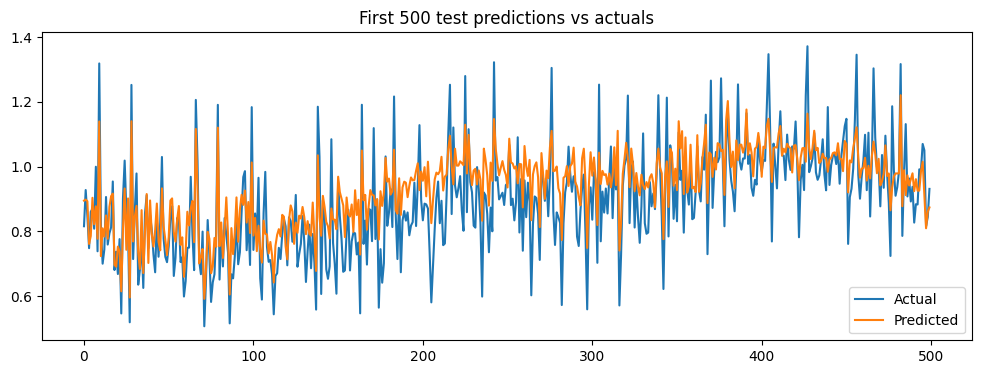

Test error l: 0.7232067160271589
Test error r: 0.31734699200613203
Test error m: 0.5183303491763864

Test Year: 2018 | Training Years: 2016 to 2017
Train samples: 412297 | Test samples: 203209


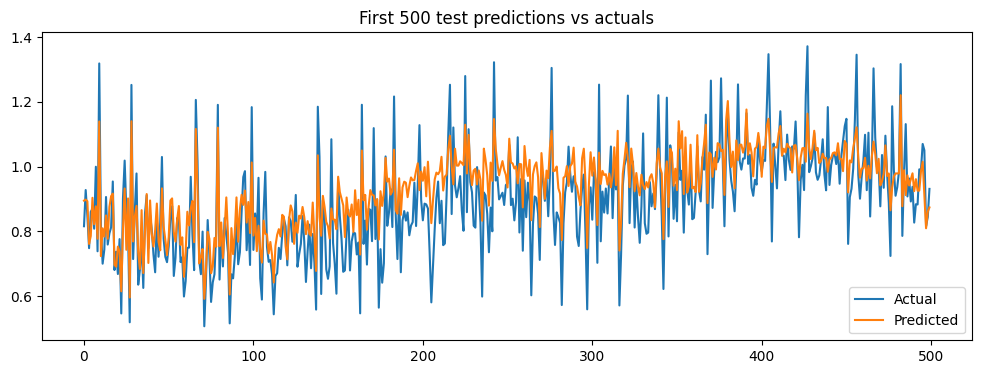

Test error l: 0.5998458336230932
Test error r: -0.28807647584037155
Test error m: 0.486234196619753

Test Year: 2019 | Training Years: 2017 to 2018
Train samples: 413164 | Test samples: 221271


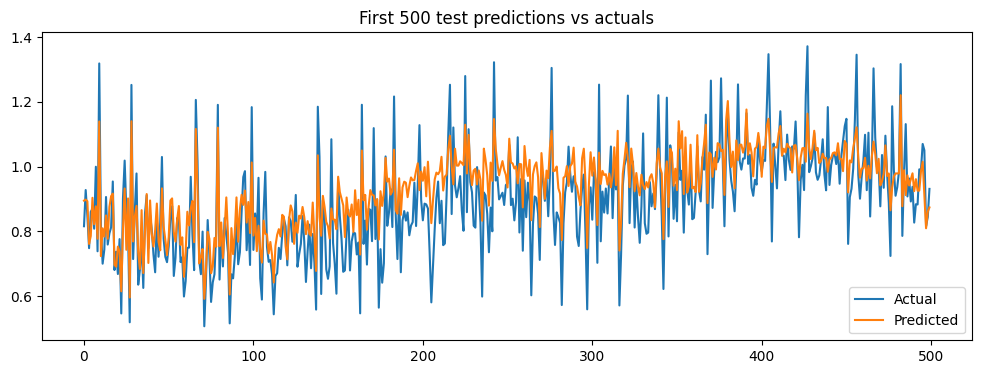

Test error l: 0.6822231015252087
Test error r: 0.2605997193034747
Test error m: 0.5703079028193594

Test Year: 2020 | Training Years: 2018 to 2019
Train samples: 424480 | Test samples: 234726


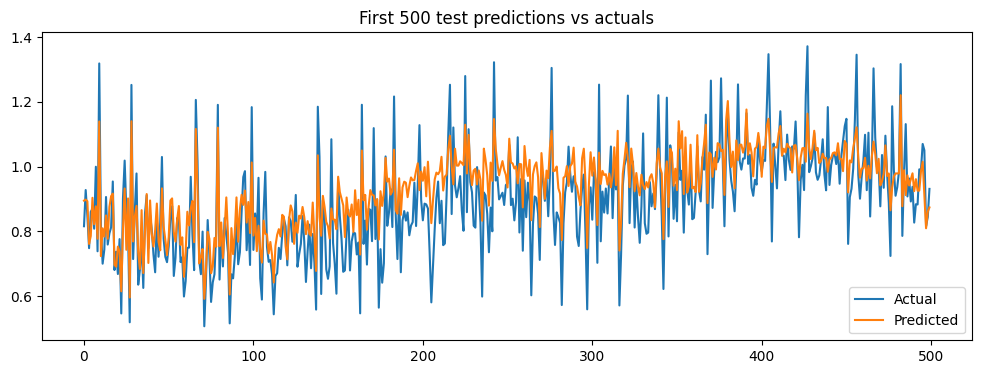

Test error l: 0.723774406001428
Test error r: 0.1136958394919475
Test error m: 0.5587702333777023

Test Year: 2021 | Training Years: 2019 to 2020
Train samples: 455997 | Test samples: 252358


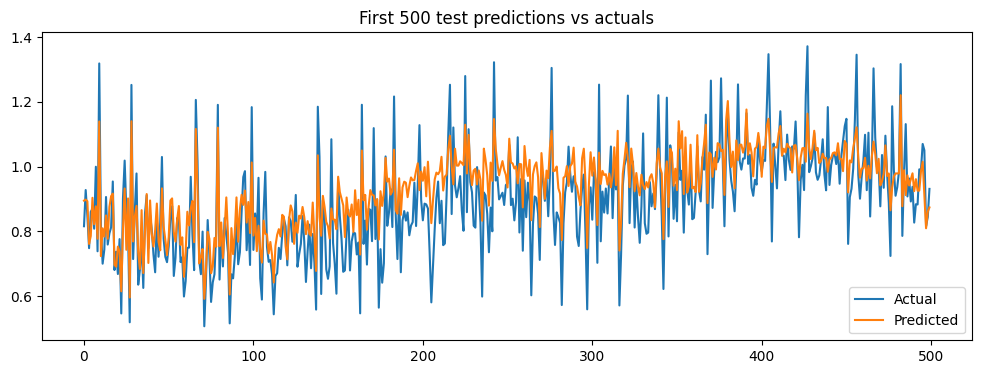

Test error l: 0.5144003990557429
Test error r: -0.8480697517957505
Test error m: 0.24872221635125868

Test Year: 2022 | Training Years: 2020 to 2021
Train samples: 487084 | Test samples: 282859


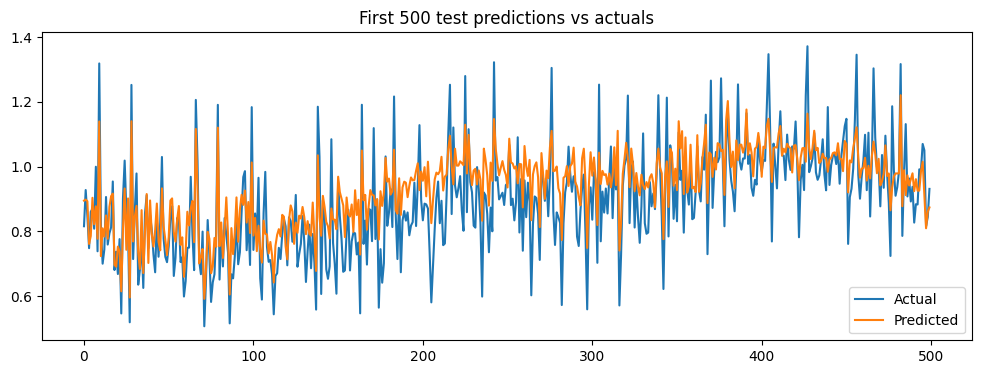

Test error l: 0.5107531751831863
Test error r: 0.43059566256797854
Test error m: 0.6471888453224773

Test Year: 2023 | Training Years: 2021 to 2022
Train samples: 535217 | Test samples: 289871


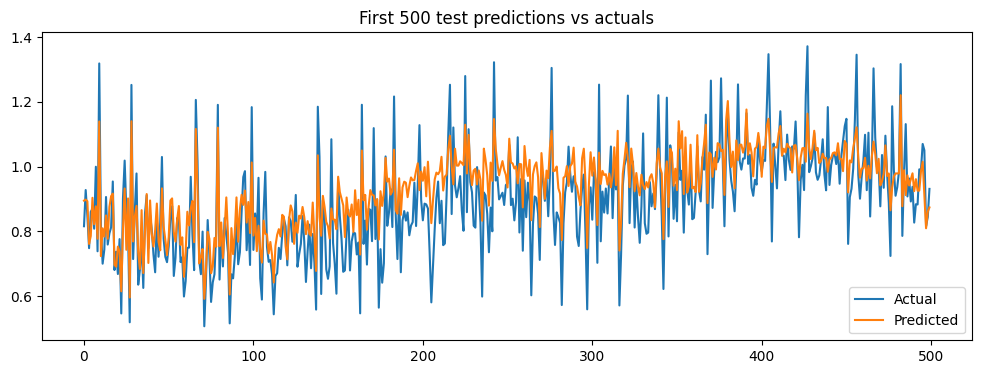

Test error l: 0.6344267990693373
Test error r: 0.36060554162729874
Test error m: 0.4143813245767528

Test Year: 2024 | Training Years: 2022 to 2023
Train samples: 572730 | Test samples: 304064


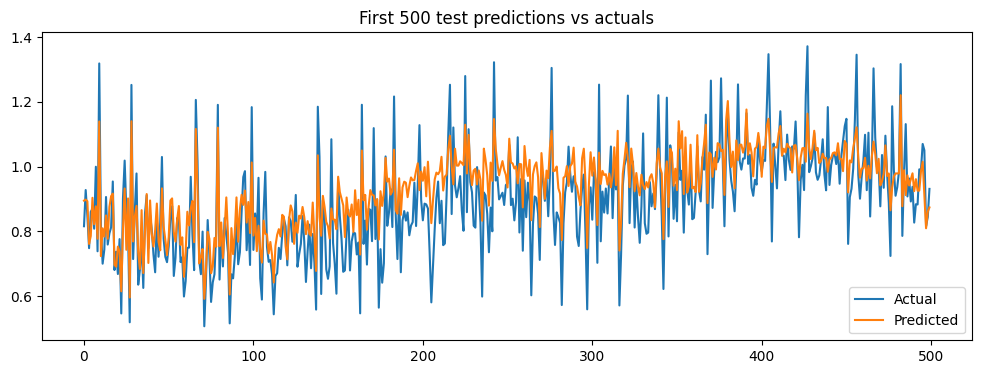

Test error l: 0.6244337349075717
Test error r: 0.20727656697948071
Test error m: 0.6017618169604503
Overall Train Metrics:
MAE: 0.06188609271135799, RMSE: 0.08155284081303112, R²: 0.8187326430183112
Overall Test Metrics:
MAE: 0.08960992012825539, RMSE: 0.1200512605482697, R²: 0.6209657980593624
================== DoubleMLPLIV Object ==================

------------------ Data summary      ------------------
Outcome variable: consumption_normalized
Treatment variable(s): ['DayAheadPriceEUR']
Cluster variable(s): ['Country']
Covariates: ['HourOfWeek_67', 'HourOfWeek_5', 'HourOfWeek_130', 'HourOfWeek_141', 'HourOfWeek_166', 'PriceArea_RO', 'HourOfWeek_162', 'HourOfWeek_51', 'HourOfWeek_83', 'HourOfWeek_138', 'HourOfWeek_152', 'HourOfWeek_116', 'HourOfWeek_32', 'HourOfWeek_104', 'block_6.0:tempbin2', 'HourOfWeek_159', 'HourOfWeek_158', 'PriceArea_BG', 'Month_10', 'HourOfWeek_13', 'HourOfWeek_85', 'PriceArea_IT_SARD', 'HourOfWeek_137', 'HourOfWeek_146', 'block_6.0:Solar_MWh', 'PriceArea_SK'

In [ ]:
dml_pliv_obj_another_set, filtered_data_another_set, importance_df_another_set, fold_metrics_df_another_set, importance_all_folds_df_another_set, fold_coefficients_another_set = dml_rolling_window(processed_data,
                                                                                                                             covariates,
                                                                                                                             dependent_variable = 'consumption_normalized',
                                                                                                                             manual_params_l=manual_params_l,
                                                                                                                             manual_params_r=manual_params_r,
                                                                                                                             manual_params_m=manual_params_m)


In [ ]:
covariates

['HourOfWeek_67',
 'HourOfWeek_5',
 'HourOfWeek_130',
 'HourOfWeek_141',
 'HourOfWeek_166',
 'PriceArea_RO',
 'HourOfWeek_162',
 'HourOfWeek_51',
 'HourOfWeek_83',
 'HourOfWeek_138',
 'HourOfWeek_152',
 'HourOfWeek_116',
 'HourOfWeek_32',
 'HourOfWeek_104',
 'block_6.0:tempbin2',
 'HourOfWeek_159',
 'HourOfWeek_158',
 'PriceArea_BG',
 'Month_10',
 'HourOfWeek_13',
 'HourOfWeek_85',
 'PriceArea_IT_SARD',
 'HourOfWeek_137',
 'HourOfWeek_146',
 'block_6.0:Solar_MWh',
 'PriceArea_SK',
 'HourOfWeek_101',
 'HourOfWeek_29',
 'Month_4',
 'HourOfWeek_59',
 'HourOfWeek_64',
 'PriceArea_IT_SICI',
 'HourOfWeek_77',
 'HourOfWeek_103',
 'HourOfWeek_153',
 'HourOfWeek_24',
 'PriceArea_SE_4',
 'block_5.0:Solar_MWh',
 'HourOfWeek_3',
 'HourOfWeek_22',
 'HourOfWeek_160',
 'PriceArea_LT',
 'HourOfWeek_69',
 'PriceArea_GR',
 'PriceArea_IT_CNOR',
 'HourOfWeek_117',
 'Month_9',
 'HourOfWeek_48',
 'Month_7',
 'block_3.0:Solar_MWh',
 'block_6.0:tempbin',
 'PriceArea_FI',
 'HourOfWeek_9',
 'HourOfWeek_98',
 'H

In [ ]:
covariates_regression = [var for var in covariates if var not in ['HourOfWeek_0', 'Month_1']]

In [ ]:
outcome_var = 'consumption_normalized'
treatment_var = ['DayAheadPriceEUR']
instrument_vars = ['Total_Wind_Generation']
cluster_var = 'Country'

# Prepare matrices
Y = filtered_data_another_set[outcome_var]
D = filtered_data_another_set[treatment_var]
Z = filtered_data_another_set[instrument_vars]
W = filtered_data_another_set[covariates_regression]

# Fit the IV model
iv_model_check_filter = IV2SLS(dependent=Y, exog=W, endog=D, instruments=Z).fit(cov_type='clustered', clusters=filtered_data_another_set[cluster_var])

# Summary of results
print(iv_model_check_filter.summary)

                            IV-2SLS Estimation Summary                            
Dep. Variable:     consumption_normalized   R-squared:                      0.5610
Estimator:                        IV-2SLS   Adj. R-squared:                 0.5609
No. Observations:                 1998313   F-statistic:                -2.334e+17
Date:                    Sun, Apr 06 2025   P-value (F-stat)                1.0000
Time:                            13:03:07   Distribution:                chi2(238)
Cov. Estimator:                 clustered                                         
                                                                                  
                                  Parameter Estimates                                  
                     Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------------
HourOfWeek_67           0.3508     0.0238     14.735     0.0000      0.3

In [ ]:
fold_coefficients_another_set

[{'Year': 2017,
  'coef': array([-0.00073581]),
  'se': array([0.0001637]),
  't': array([-4.49490011]),
  'p': array([6.96026138e-06])},
 {'Year': 2018,
  'coef': array([-0.00259734]),
  'se': array([0.00127399]),
  't': array([-2.03874251]),
  'p': array([0.04147573])},
 {'Year': 2019,
  'coef': array([0.00012224]),
  'se': array([0.00155627]),
  't': array([0.07854521]),
  'p': array([0.93739437])},
 {'Year': 2020,
  'coef': array([-0.00269823]),
  'se': array([0.00050836]),
  't': array([-5.30774746]),
  'p': array([1.1098827e-07])},
 {'Year': 2021,
  'coef': array([0.00047238]),
  'se': array([7.12536741e-05]),
  't': array([6.6295695]),
  'p': array([3.36667285e-11])},
 {'Year': 2022,
  'coef': array([-0.00037111]),
  'se': array([0.00010065]),
  't': array([-3.68706842]),
  'p': array([0.00022685])},
 {'Year': 2023,
  'coef': array([-0.0004864]),
  'se': array([0.00010729]),
  't': array([-4.53339994]),
  'p': array([5.80417686e-06])},
 {'Year': 2024,
  'coef': array([-0.0011164

In [ ]:
filtered_data_another_set.to_csv("first_normalise_another.csv", index=False)
importance_df_another_set.to_csv("first_normalise_importance_df_another.csv", index=False)
fold_coefficients_another_set = pd.DataFrame(fold_coefficients_another_set)
fold_coefficients_another_set.to_csv("fold_coefficients_another_set.csv", index=False)

In [ ]:
importance_df_another_set

Feature  Mean Importance  Std Importance
156  block_1.0:tempbin2         0.050746        0.005784
137      HourOfWeek_149         0.035076        0.003486
204      HourOfWeek_150         0.028248        0.002638
169      HourOfWeek_125         0.027305        0.002395
14   block_6.0:tempbin2         0.022345        0.002768
..                  ...              ...             ...
103        PriceArea_LV         0.000000        0.000000
186   block_4.0:tempbin         0.000000        0.000000
210   block_5.0:tempbin         0.000000        0.000000
50    block_6.0:tempbin         0.000000        0.000000
173      PriceArea_NO_1         0.000000        0.000000

[239 rows x 3 columns]

Test - consumption_normalized Metrics:
  MAE: 0.0896
  RMSE: 0.1201
  R²: 0.6210
consumption_normalized Range: Min = 0.0, Max = 2.7072245076569836, Range = 2.7072245076569836
MAE as percentage of range: 3.31%
RMSE as percentage of range: 4.43%


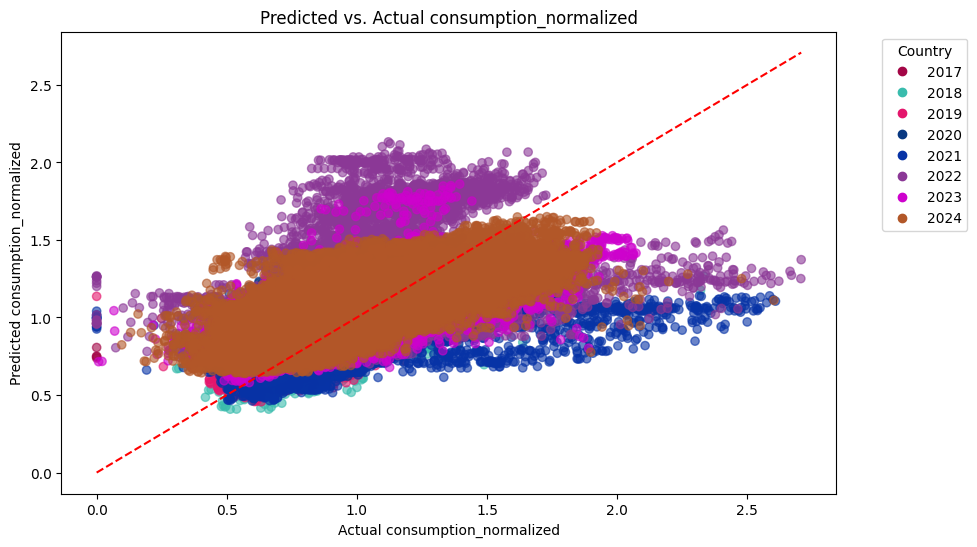

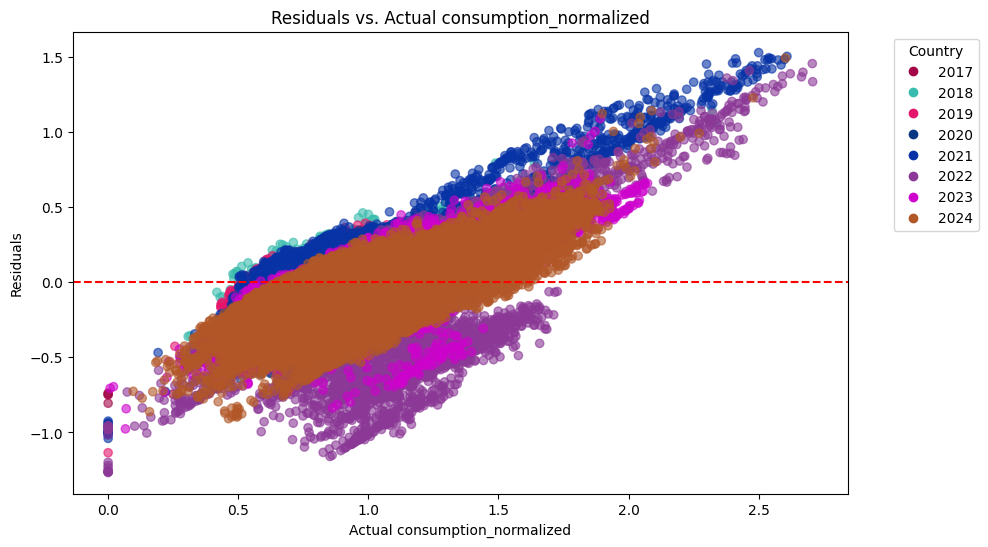

In [ ]:
result = evaluate_predictions_country(
    predictions=dml_pliv_obj_another_set.predictions['ml_l'].ravel(),
    true_values=filtered_data_another_set['consumption_normalized'],
    target_name="consumption_normalized",
    country_values=filtered_data_another_set['Year']  # Use the Country column
)

## Importance

In [ ]:
# Get top 50 features by mean importance
top_50_features = importance_df_another_set.sort_values(by='Mean Importance', ascending=False)['Feature'].head(50).tolist()


Test Year: 2017 | Training Years: 2015 to 2016
Train samples: 401818 | Test samples: 209955
Best L Parameters: {'learning_rate': 0.03, 'max_depth': 6, 'n_estimators': 1000}
Best R Parameters: {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500}
Best M Parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 500}


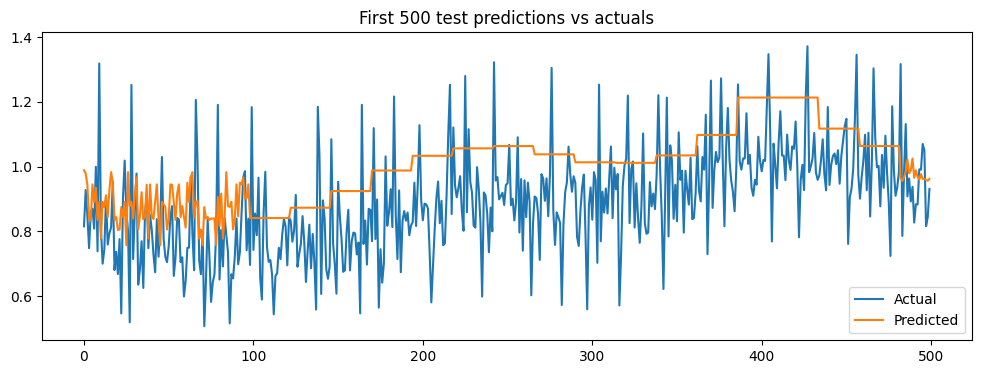

Test error l: 0.5582718461938836
Test error r: 0.07625607154286607
Test error m: 0.0007223010489686432

Test Year: 2018 | Training Years: 2016 to 2017
Train samples: 412297 | Test samples: 203209


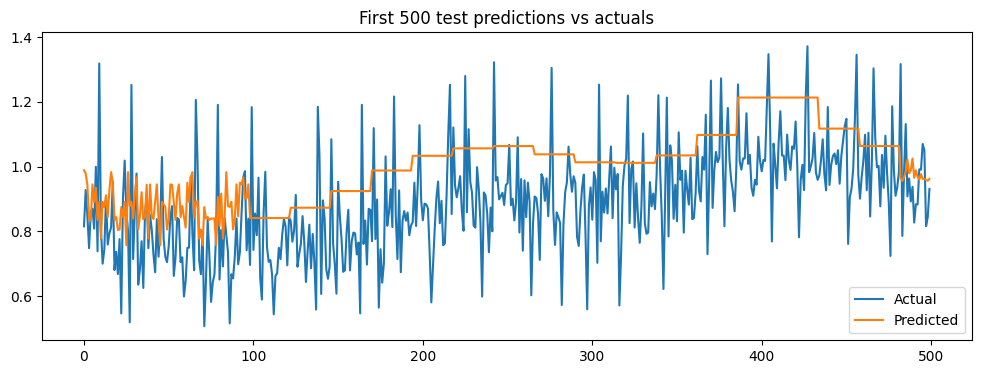

Test error l: 0.5454718521487971
Test error r: -0.3610581193255544
Test error m: 0.00033248926667939216

Test Year: 2019 | Training Years: 2017 to 2018
Train samples: 413164 | Test samples: 221271


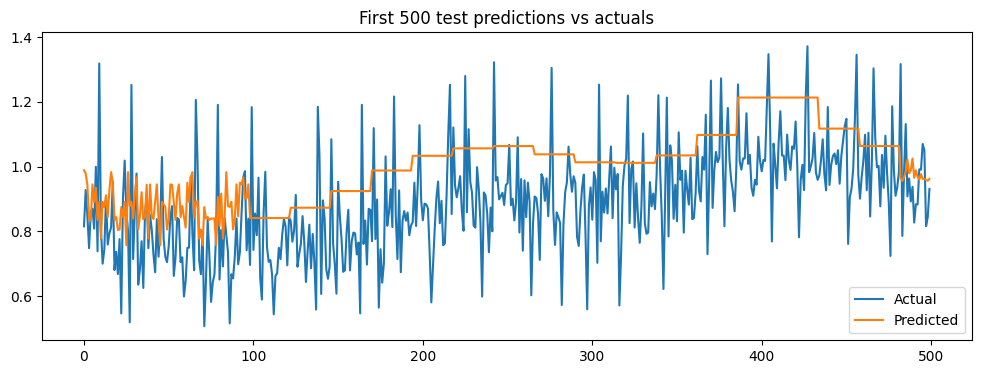

Test error l: 0.5802459254351191
Test error r: 0.2141159230654318
Test error m: -0.0021390560313503393

Test Year: 2020 | Training Years: 2018 to 2019
Train samples: 424480 | Test samples: 234726


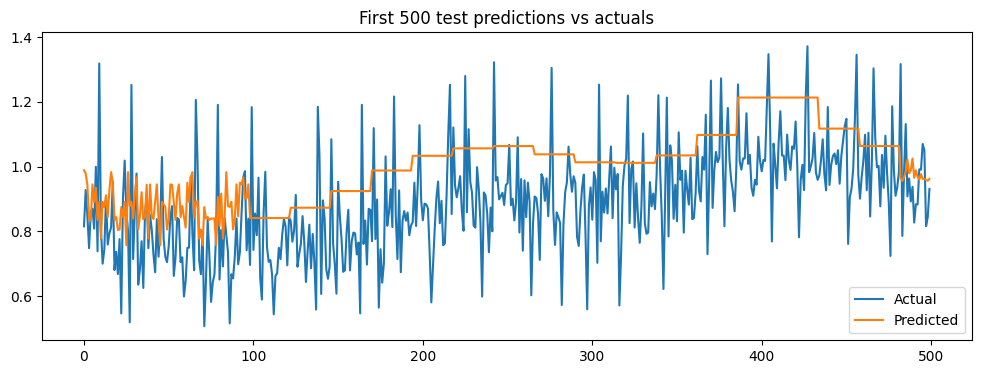

Test error l: 0.5440507333833726
Test error r: -0.3819883770330885
Test error m: 0.0015769195336768904

Test Year: 2021 | Training Years: 2019 to 2020
Train samples: 455997 | Test samples: 252358


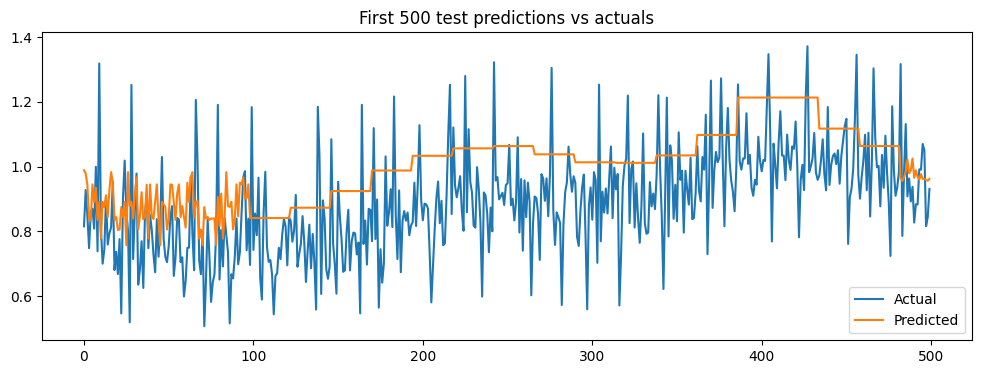

Test error l: 0.5001477218660941
Test error r: -0.7607127151831528
Test error m: 0.005497522502801111

Test Year: 2022 | Training Years: 2020 to 2021
Train samples: 487084 | Test samples: 282859


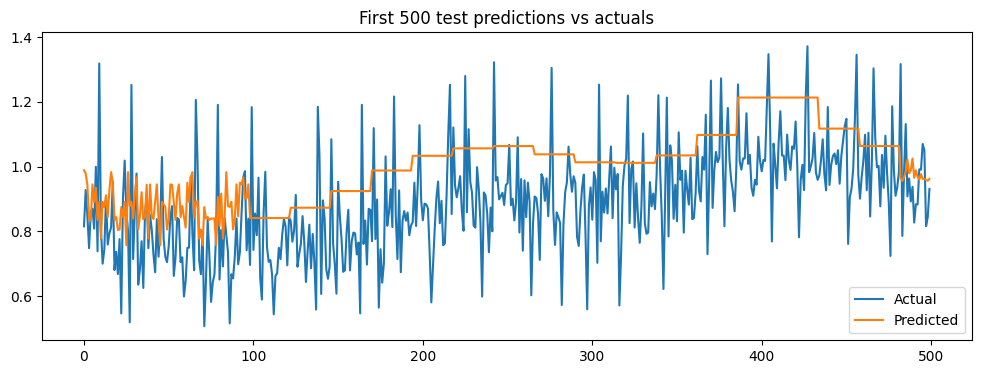

Test error l: 0.4915366247116776
Test error r: -1.1562108387643564
Test error m: 0.010360242557765131

Test Year: 2023 | Training Years: 2021 to 2022
Train samples: 535217 | Test samples: 289871


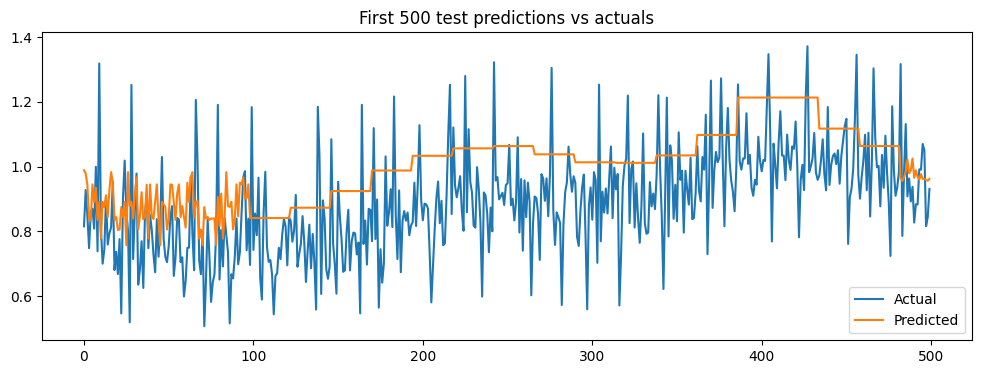

Test error l: 0.4582038652540108
Test error r: -2.688721801213266
Test error m: 0.001859084718131454

Test Year: 2024 | Training Years: 2022 to 2023
Train samples: 572730 | Test samples: 304064


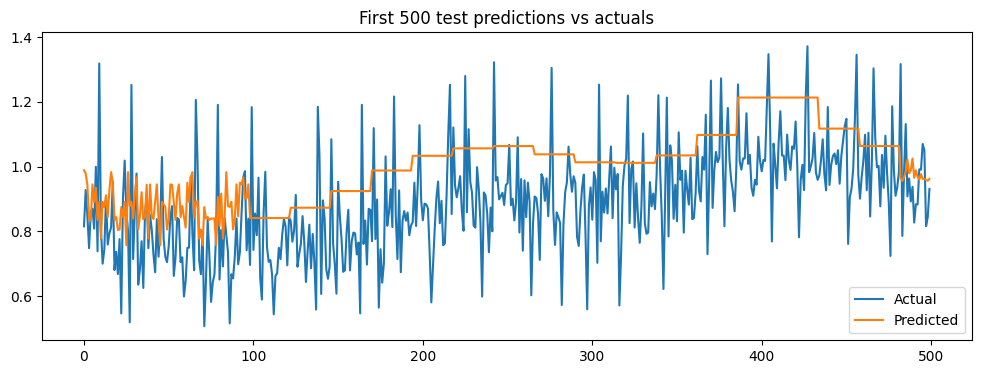

Test error l: 0.4601787604739278
Test error r: -1.87579264489128
Test error m: 0.009988148459402657
Overall Train Metrics:
MAE: 0.09903280108670652, RMSE: 0.13024537696502614, R²: 0.5376551240540673
Overall Test Metrics:
MAE: 0.10364113235779669, RMSE: 0.13664503089686958, R²: 0.5089421734075583
================== DoubleMLPLIV Object ==================

------------------ Data summary      ------------------
Outcome variable: consumption_normalized
Treatment variable(s): ['DayAheadPriceEUR']
Cluster variable(s): ['Country']
Covariates: ['block_1.0:tempbin2', 'HourOfWeek_149', 'HourOfWeek_150', 'HourOfWeek_125', 'block_6.0:tempbin2', 'HourOfWeek_126', 'HourOfWeek_151', 'HourOfWeek_157', 'HourOfWeek_158', 'HourOfWeek_156', 'HourOfWeek_155', 'HourOfWeek_154', 'HourOfWeek_159', 'HourOfWeek_153', 'HourOfWeek_164', 'HourOfWeek_140', 'HourOfWeek_56', 'Month_1', 'HourOfWeek_32', 'Month_2', 'HourOfWeek_80', 'HourOfWeek_134', 'HourOfWeek_55', 'HourOfWeek_132', 'HourOfWeek_133', 'HourOfWeek_31', 

In [ ]:
dml_pliv_obj_another_set_importance, filtered_data_another_set_importance, importance_df_another_set_importance, fold_metrics_df_another_set_importance, importance_all_folds_df_another_set_importance, fold_coefficients_another_set_importance = dml_rolling_window(
    processed_data,
    top_50_features,  # 👈 only top features
    param_dist_xgb=param_dist_xgb,
    dependent_variable='consumption_normalized'
)


In [ ]:
filtered_data_another_set_importance.to_csv("filtered_data_another_set_importance.csv", index=False)
importance_df_another_set_importance.to_csv("importance_df_another_set_importance.csv", index=False)
fold_metrics_df_another_set_importance = pd.DataFrame(fold_metrics_df_another_set_importance)
fold_metrics_df_another_set_importance.to_csv("fold_metrics_df_another_set_importance.csv", index=False)

In [ ]:
outcome_var = 'consumption_normalized'
treatment_var = ['DayAheadPriceEUR']
instrument_vars = ['Total_Wind_Generation']
cluster_var = 'Country'

# Prepare matrices
Y = filtered_data_another_set_importance[outcome_var]
D = filtered_data_another_set_importance[treatment_var]
Z = filtered_data_another_set_importance[instrument_vars]
W = filtered_data_another_set_importance[top_50_features]

# Fit the IV model
iv_model_check_filter = IV2SLS(dependent=Y, exog=W, endog=D, instruments=Z).fit(cov_type='clustered', clusters=filtered_data_another_set_importance[cluster_var])

# Summary of results
print(iv_model_check_filter.summary)

                            IV-2SLS Estimation Summary                            
Dep. Variable:     consumption_normalized   R-squared:                     -1.7553
Estimator:                        IV-2SLS   Adj. R-squared:                -1.7554
No. Observations:                 1998313   F-statistic:                  9.49e+12
Date:                    Sun, Apr 06 2025   P-value (F-stat)                0.0000
Time:                            13:05:19   Distribution:                 chi2(51)
Cov. Estimator:                 clustered                                         
                                                                                  
                                 Parameter Estimates                                  
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
block_1.0:tempbin2    -0.3324     0.0477    -6.9697     0.0000     -0.4259 

## Test peak


Test Year: 2017 | Training Years: 2015 to 2016
Train samples: 401818 | Test samples: 209955


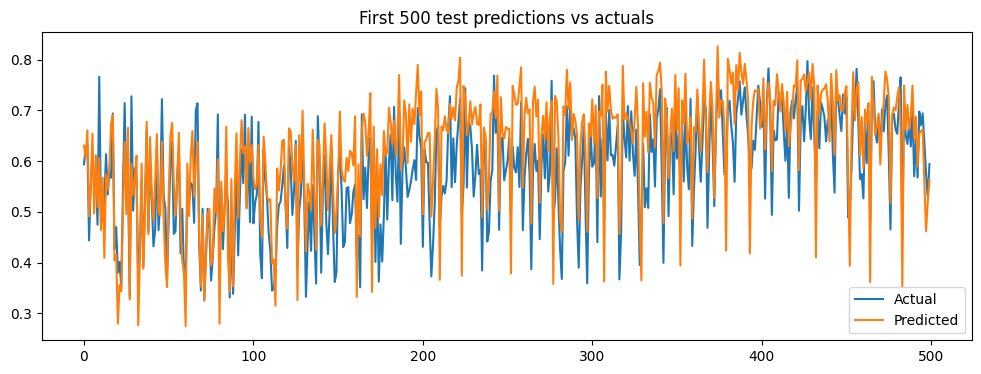

Test error l: 0.6442706868711015
Test error r: 0.31734699200613203
Test error m: 0.5183303491763864

Test Year: 2018 | Training Years: 2016 to 2017
Train samples: 412297 | Test samples: 203209


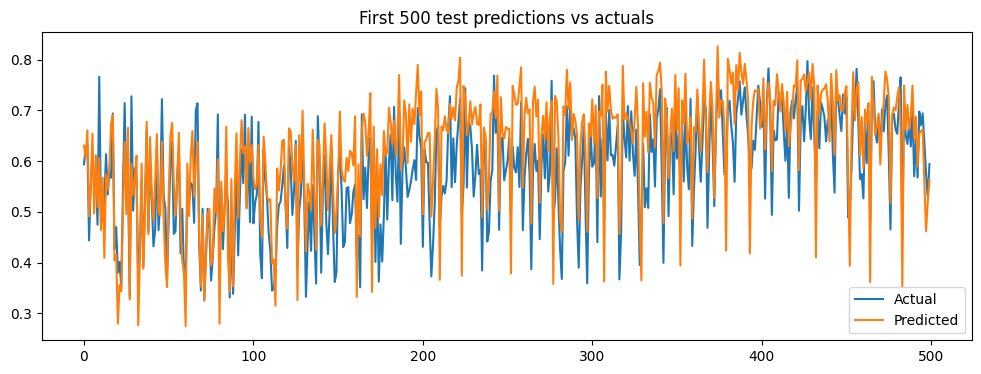

Test error l: 0.6087578432724731
Test error r: -0.28807647584037155
Test error m: 0.486234196619753

Test Year: 2019 | Training Years: 2017 to 2018
Train samples: 413164 | Test samples: 221271


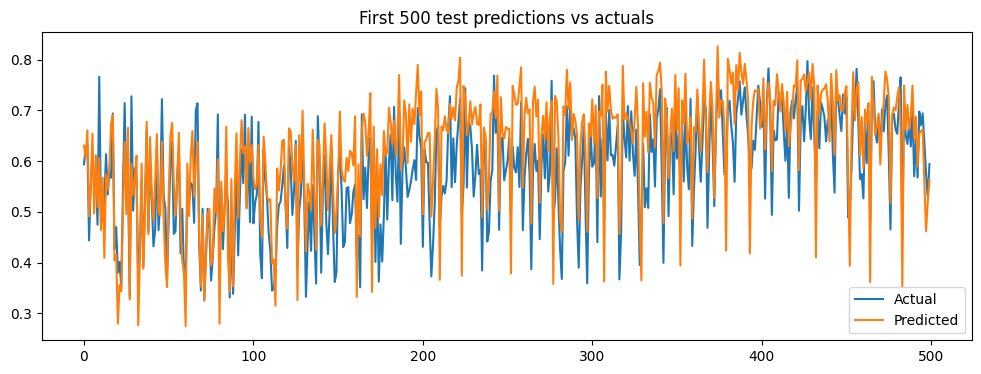

Test error l: 0.6509034886982812
Test error r: 0.2605997193034747
Test error m: 0.5703079028193594

Test Year: 2020 | Training Years: 2018 to 2019
Train samples: 424480 | Test samples: 234726


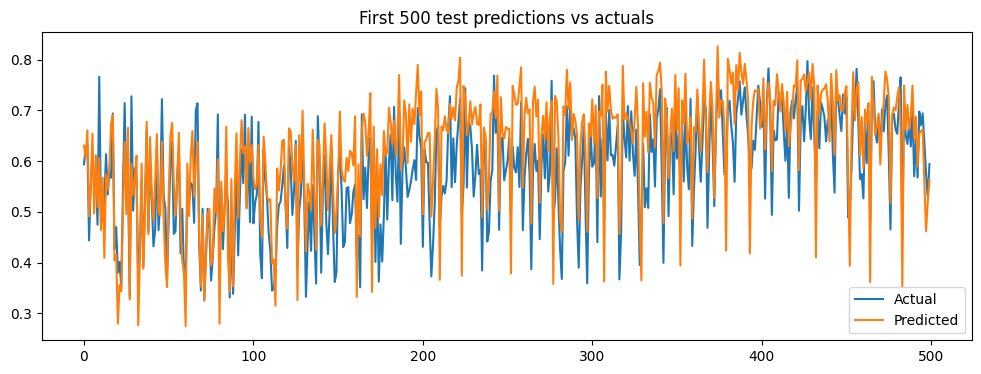

Test error l: 0.6199558053912626
Test error r: 0.1136958394919475
Test error m: 0.5587702333777023

Test Year: 2021 | Training Years: 2019 to 2020
Train samples: 455997 | Test samples: 252358


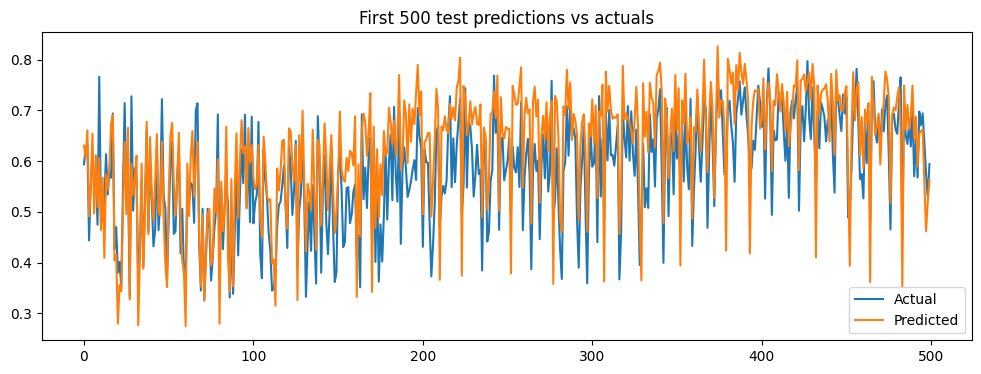

Test error l: 0.49699061520072196
Test error r: -0.8480697517957505
Test error m: 0.24872221635125868

Test Year: 2022 | Training Years: 2020 to 2021
Train samples: 487084 | Test samples: 282859


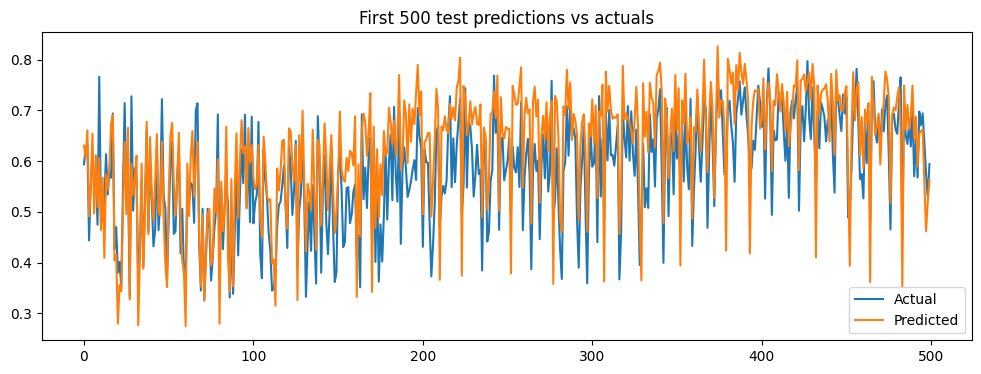

Test error l: 0.43281669234442377
Test error r: 0.43059566256797854
Test error m: 0.6471888453224773

Test Year: 2023 | Training Years: 2021 to 2022
Train samples: 535217 | Test samples: 289871


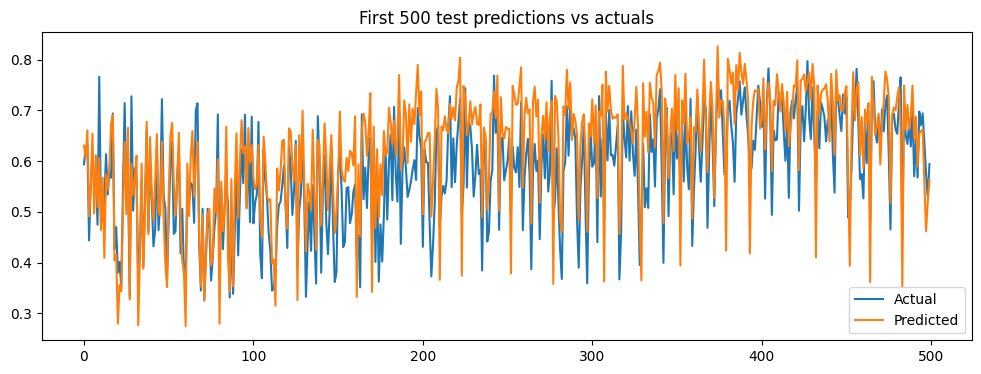

Test error l: 0.614460237755819
Test error r: 0.36060554162729874
Test error m: 0.4143813245767528

Test Year: 2024 | Training Years: 2022 to 2023
Train samples: 572730 | Test samples: 304064


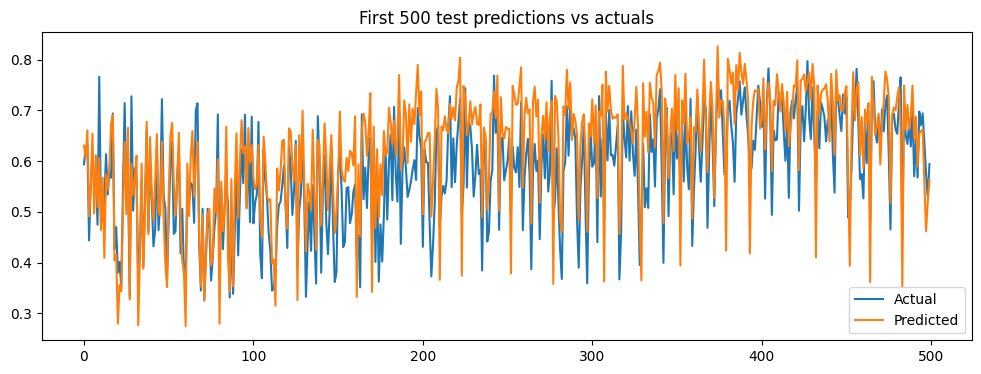

Test error l: 0.3500497336043241
Test error r: 0.20727656697948071
Test error m: 0.6017618169604503
Overall Train Metrics:
MAE: 0.039712738580140655, RMSE: 0.05161053590364646, R²: 0.8620988858469595
Overall Test Metrics:
MAE: 0.0713895181651181, RMSE: 0.09501868035680816, R²: 0.5433041024477265
================== DoubleMLPLIV Object ==================

------------------ Data summary      ------------------
Outcome variable: consumption_norm_peak
Treatment variable(s): ['DayAheadPriceEUR']
Cluster variable(s): ['Country']
Covariates: ['HourOfWeek_67', 'HourOfWeek_5', 'HourOfWeek_130', 'HourOfWeek_141', 'HourOfWeek_166', 'PriceArea_RO', 'HourOfWeek_162', 'HourOfWeek_51', 'HourOfWeek_83', 'HourOfWeek_138', 'HourOfWeek_152', 'HourOfWeek_116', 'HourOfWeek_32', 'HourOfWeek_104', 'block_6.0:tempbin2', 'HourOfWeek_159', 'HourOfWeek_158', 'PriceArea_BG', 'Month_10', 'HourOfWeek_13', 'HourOfWeek_85', 'PriceArea_IT_SARD', 'HourOfWeek_137', 'HourOfWeek_146', 'block_6.0:Solar_MWh', 'PriceArea_SK'

In [ ]:
dml_pliv_obj_peak, filtered_data_peak, importance_df_peak, fold_metrics_df_peak, importance_all_folds_df_peak, fold_coefficients_peak = dml_rolling_window(processed_data,
                                                                                                                             covariates,
                                                                                                                             dependent_variable = 'consumption_norm_peak',
                                                                                                                             manual_params_l=manual_params_l,
                                                                                                                             manual_params_r=manual_params_r,
                                                                                                                             manual_params_m=manual_params_m)


In [ ]:
outcome_var = 'consumption_normalized'
treatment_var = ['DayAheadPriceEUR']
instrument_vars = ['Total_Wind_Generation']
cluster_var = 'Country'

# Prepare matrices
Y = filtered_data_another_set_importance[outcome_var]
D = filtered_data_another_set_importance[treatment_var]
Z = filtered_data_another_set_importance[instrument_vars]
W = filtered_data_another_set_importance[top_50_features]

# Fit the IV model
iv_model_check_filter = IV2SLS(dependent=Y, exog=W, endog=D, instruments=Z).fit(cov_type='clustered', clusters=filtered_data_another_set_importance[cluster_var])

# Summary of results
print(iv_model_check_filter.summary)

In [ ]:
filtered_data_peak.columns

Index(['Unnamed: 0', 'Time', 'ConsumptionValue', 'DayAheadPriceEUR',
       'WeatherWindSpeed', 'WeatherTemperature', 'Year', 'Day', 'Hour',
       'WeatherTemperature_F',
       ...
       'block_4.0:tempbin2', 'block_4.0:Solar_MWh', 'block_5.0:tempbin',
       'block_5.0:tempbin2', 'block_5.0:Solar_MWh', 'block_6.0:tempbin',
       'block_6.0:tempbin2', 'block_6.0:Solar_MWh', 'Prrediction',
       'Residuals'],
      dtype='object', length=277)

Test - consumption_norm_peak Metrics:
  MAE: 0.0714
  RMSE: 0.0950
  R²: 0.5433
consumption_norm_peak Range: Min = 0.0, Max = 1.0, Range = 1.0
MAE as percentage of range: 7.14%
RMSE as percentage of range: 9.50%


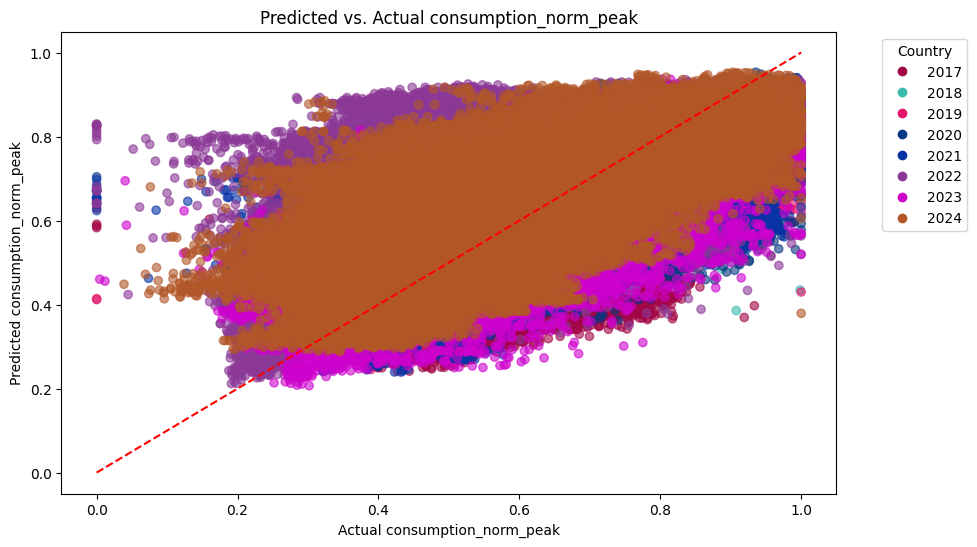

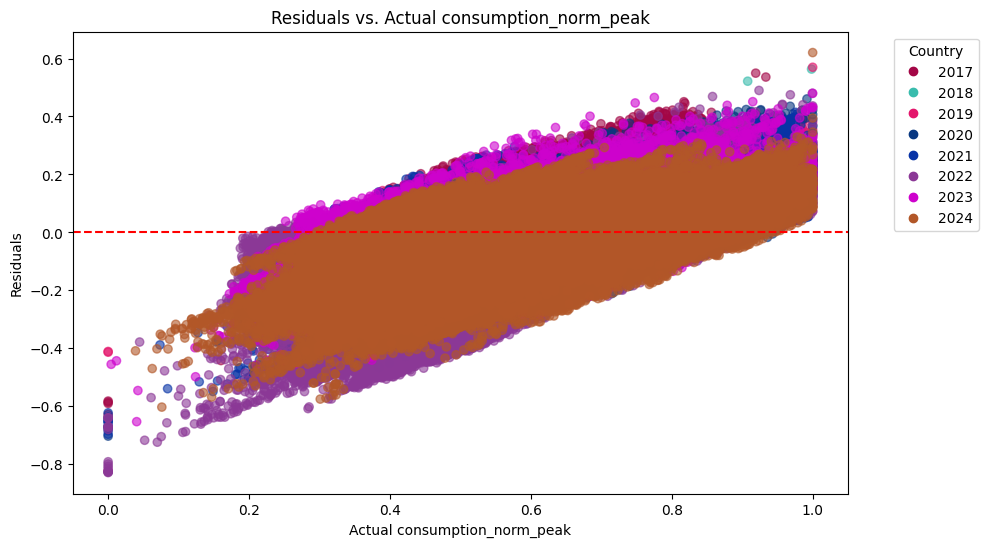

In [ ]:
result = evaluate_predictions_country(
    predictions=filtered_data_peak['Prrediction'],
    true_values=filtered_data_peak['consumption_norm_peak'],
    target_name="consumption_norm_peak",
    country_values=filtered_data_peak['Year']  # Use the Country column
)

In [ ]:
top_50_features_peak = importance_df_peak.sort_values(by='Mean Importance', ascending=False)['Feature'].head(50).tolist()


Test Year: 2017 | Training Years: 2015 to 2016
Train samples: 401818 | Test samples: 209955


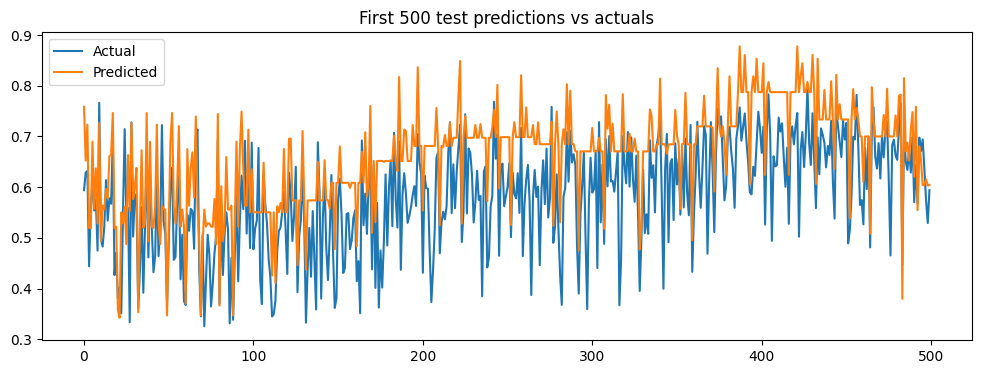

Test error l: 0.5752533732353095
Test error r: 0.13097402593902174
Test error m: 0.5751305773607827

Test Year: 2018 | Training Years: 2016 to 2017
Train samples: 412297 | Test samples: 203209


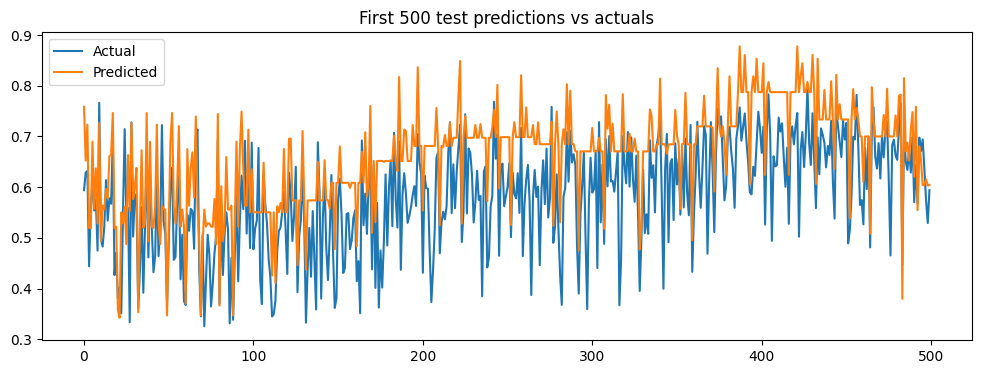

Test error l: 0.5602492643846936
Test error r: -0.3081460804315628
Test error m: 0.6071753104340669

Test Year: 2019 | Training Years: 2017 to 2018
Train samples: 413164 | Test samples: 221271


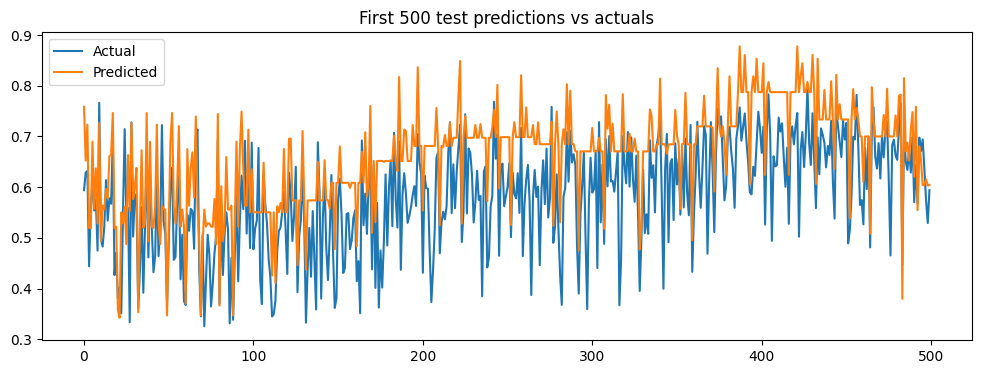

Test error l: 0.5949309682930333
Test error r: 0.23381669105475444
Test error m: 0.6206072719338607

Test Year: 2020 | Training Years: 2018 to 2019
Train samples: 424480 | Test samples: 234726


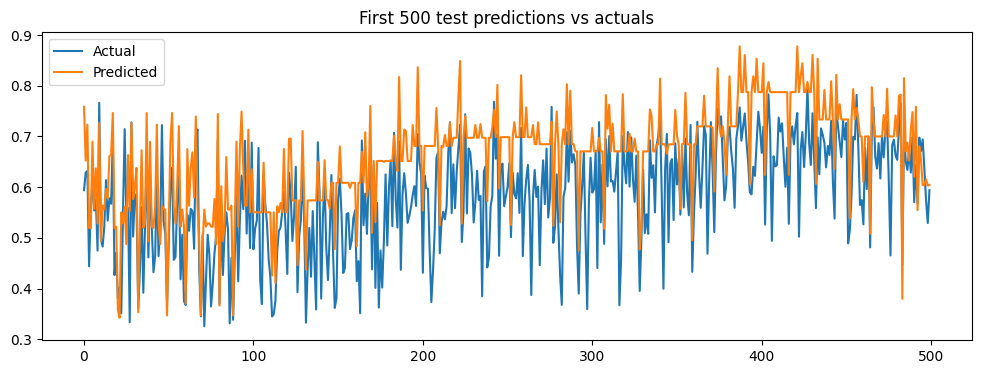

Test error l: 0.41564185680496346
Test error r: -0.38670000142789074
Test error m: 0.635581131551545

Test Year: 2021 | Training Years: 2019 to 2020
Train samples: 455997 | Test samples: 252358


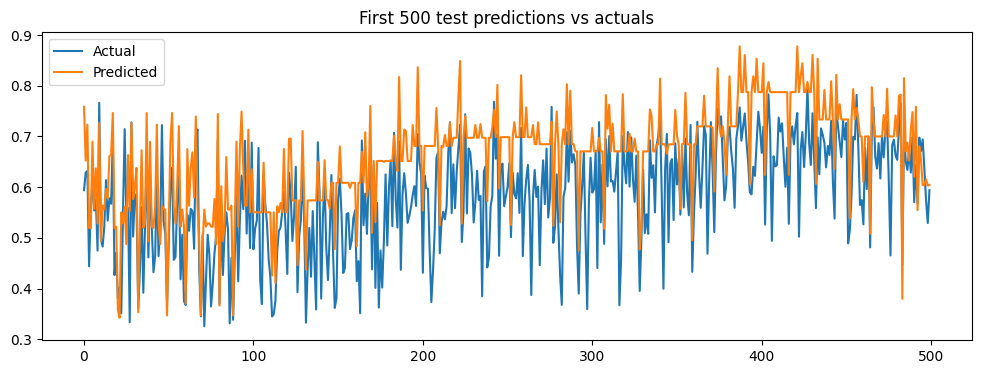

Test error l: 0.4549359329535354
Test error r: -0.7473680045622617
Test error m: 0.5964886784969192

Test Year: 2022 | Training Years: 2020 to 2021
Train samples: 487084 | Test samples: 282859


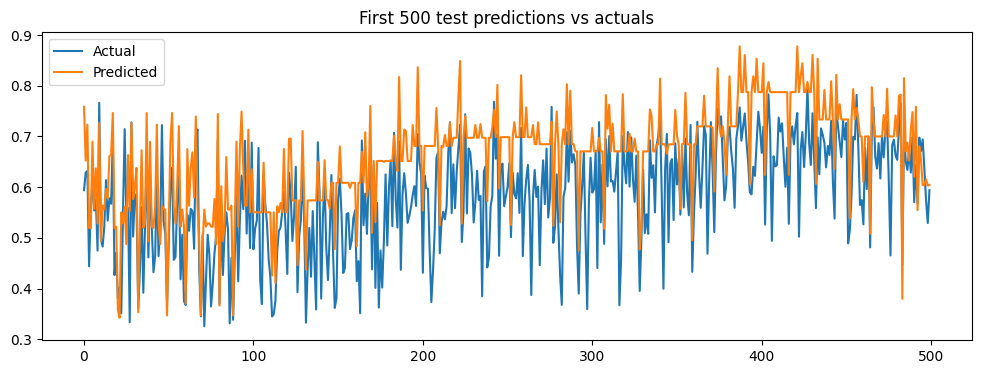

Test error l: 0.4960239287259556
Test error r: -1.1320167836190764
Test error m: 0.6197559073127794

Test Year: 2023 | Training Years: 2021 to 2022
Train samples: 535217 | Test samples: 289871


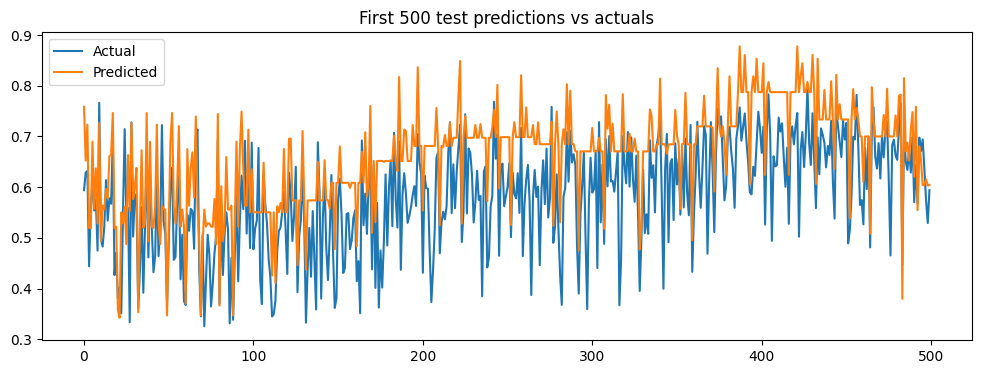

Test error l: 0.44103090157009595
Test error r: -2.946988155254391
Test error m: 0.586277977287144

Test Year: 2024 | Training Years: 2022 to 2023
Train samples: 572730 | Test samples: 304064


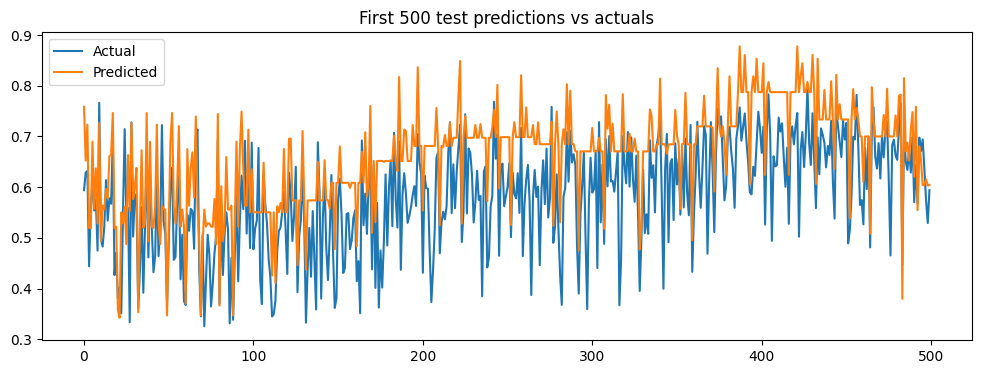

Test error l: 0.3925143815404891
Test error r: -1.9648866465956747
Test error m: 0.6189001222916052
Overall Train Metrics:
MAE: 0.07004914864057563, RMSE: 0.09008079913365824, R²: 0.5798972752943011
Overall Test Metrics:
MAE: 0.07703531721166156, RMSE: 0.10019378712576053, R²: 0.4922023273161449
================== DoubleMLPLIV Object ==================

------------------ Data summary      ------------------
Outcome variable: consumption_norm_peak
Treatment variable(s): ['DayAheadPriceEUR']
Cluster variable(s): ['Country']
Covariates: ['block_1.0:tempbin2', 'PriceArea_IT_CALA', 'HourOfWeek_149', 'PriceArea_DK_1', 'HourOfWeek_150', 'HourOfWeek_125', 'PriceArea_BE', 'PriceArea_IT_SUD', 'block_6.0:tempbin2', 'HourOfWeek_158', 'HourOfWeek_157', 'PriceArea_DE_LU', 'HourOfWeek_56', 'HourOfWeek_159', 'HourOfWeek_151', 'HourOfWeek_126', 'HourOfWeek_134', 'PriceArea_SK', 'HourOfWeek_156', 'HourOfWeek_32', 'HourOfWeek_153', 'HourOfWeek_80', 'HourOfWeek_155', 'HourOfWeek_135', 'HourOfWeek_133', '

In [ ]:
dml_pliv_obj_peak, filtered_data_peak, importance_df_peak, fold_metrics_df_peak, importance_all_folds_df_peak, fold_coefficients_peak = dml_rolling_window(processed_data,
                                                                                                                             top_50_features_peak,
                                                                                                                             dependent_variable = 'consumption_norm_peak',
                                                                                                                             manual_params_l=manual_params_l,
                                                                                                                             manual_params_r=manual_params_r,
                                                                                                                             manual_params_m=manual_params_m)


Test - consumption_norm_peak Metrics:
  MAE: 0.0770
  RMSE: 0.1002
  R²: 0.4922
consumption_norm_peak Range: Min = 0.0, Max = 1.0, Range = 1.0
MAE as percentage of range: 7.70%
RMSE as percentage of range: 10.02%


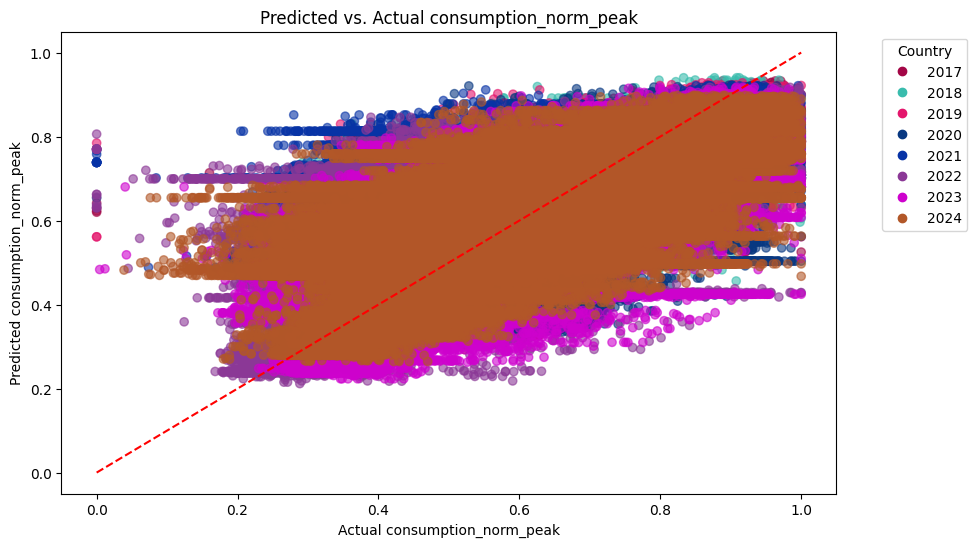

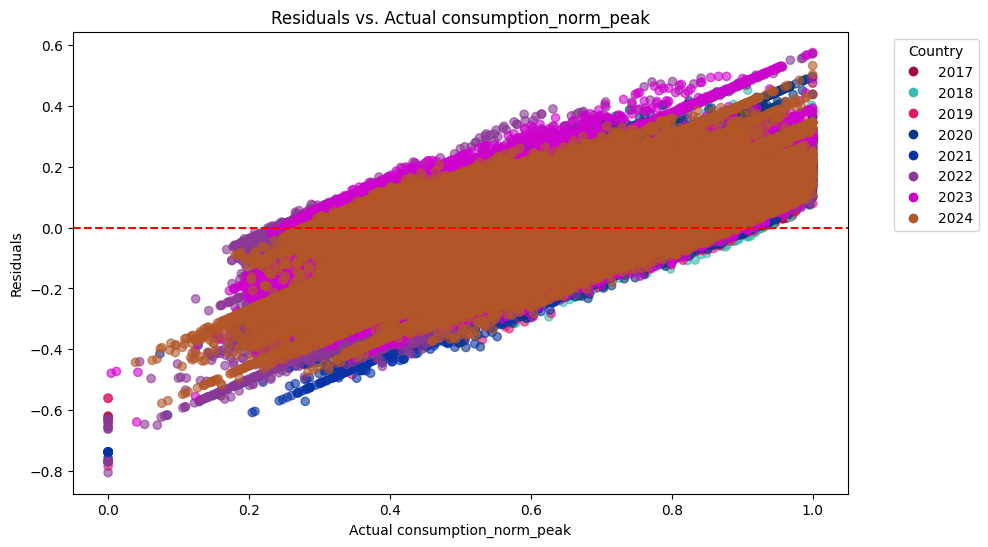

In [ ]:
result = evaluate_predictions_country(
    predictions=filtered_data_peak['Prrediction'],
    true_values=filtered_data_peak['consumption_norm_peak'],
    target_name="consumption_norm_peak",
    country_values=filtered_data_peak['Year']  # Use the Country column
)